In [123]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

In [124]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [125]:
def solvePDE(I, a, L, dt,F, T, lam, solveControl, kernel):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx)
    return u, x

def solveIntegralFD(X, nx, x, lam):
    k = np.zeros((len(x), len(x)))
    # First we calculate a at each timestep
    a = lam
    
    # FD LOOP
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(x)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i]-dx/4.0*(a[i-1] + a[i])
        k[i+1][i] = k[i][i] - dx/2 * a[i]
        for j in range(1, i):
                k[i+1][j] = -k[i-1][j] + k[i][j+1] + k[i][j-1] + a[j]*(dx**2)*(k[i][j+1]+k[i][j-1])/2
    return k

def solveLambdaFunction(x, gamma):
    lam = np.zeros(nx)
    for idx, val in enumerate(x):
        lam[idx] = 5
    return lam

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx+1]*u[0:nx+1])*dx


def openLoop(u, kernel, nx, dx):
    return 0

def solveKernel(x, y, lam):
    nx = len(x)
    ny = len(y)
    kernel = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            if i > j:
                root = math.sqrt(lam*(x[i]**2 - y[j]**2))
                kernel[i][j] = -lam*y[j] * scipy.special.i1(root)/root
            elif i == j:
                kernel[i][j] = -lam/2*x[i] 
    return kernel

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

In [126]:
X = 1
dx = 0.005
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)


T = 1.5
dt = 0.00001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt, dtype=np.float32)

In [137]:
# DATASET GENERATION. Takes about 2 minutes. 
# uarr = []
# karr = []
# uopenarr =[]
# lamValArr = []
# lamArr = np.random.uniform(4, 9, 1000)
# print(lamArr.shape)
# for i in range(1000):
#     init_cond = np.zeros(nx+1)
#     lam = np.zeros(nx+1)
#     for j in range(nx+1):
#         init_cond[j] = 10
#         # Chebyshev polynomials
#         lam[j] = 50*math.cos(lamArr[i]*math.acos(spatial[j]))
#     k = solveIntegralFD(X, nx, spatial, lam)
    
#     karr.append(k)
#     lamValArr.append(lam)

# x = []
# # Turn lambda arr into a stack
# for i in range(len(lamValArr)):
#     xval = []
#     for j in range(len(lamValArr[i])):
#         xval.append(lamValArr[i])
#     x.append(xval)
# x = np.array(x, dtype=np.float32)
# y = np.array(karr, dtype=np.float32)
# x = x.reshape(x.shape[0], -1)
# y = y.reshape(y.shape[0], -1)
# np.savetxt("x.dat", x)
# np.savetxt("y.dat", y)
# np.savetxt("lam.dat", lamArr)

(1000,)


In [127]:
# Build out grid
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

grids = []
grids.append(spatial)
grids.append(spatial)
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = torch.from_numpy(grid).cuda()
print(grid.shape)

torch.Size([40401, 2])


In [128]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [129]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [130]:
class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16,32, 5, stride=2)
        self.fc1 = torch.nn.Linear(73728, 1028)
        self.fc2 = torch.nn.Linear(1028, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [131]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
m = (nx+1)**2

branch = BranchNet(nx+1)

model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
print(count_params(model))

76169285


In [132]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [133]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))
        
        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.7032053740695119 36571.42359877692 35.764817810058595
50 0.6687986890319735 0.24343642327520582 0.17083865404129028
100 0.6703472218941897 0.10824868000215954 0.09952895045280456
150 0.6719116871245205 0.08285228245788151 0.07599297016859055
200 0.6708586032036692 0.059003090113401414 0.053162476420402525
250 0.6720304461196065 0.05247155999143918 0.04406929239630699
300 0.6724330738652498 0.04148545157578257 0.03724961206316948
350 0.6712096070405096 0.038208022796445425 0.034457489103078845
400 0.6701664829161018 0.03619006135397487 0.03235327675938606
450 0.6699454169720411 0.03593571008079582 0.03118108808994293


Avg Epoch Time: 0.6942775480099954
Final Testing Loss: 0.11314436979591846
Final Training Loss: 1.1696073459461331


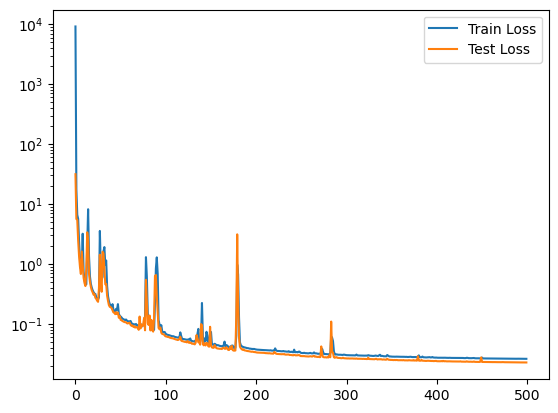

In [13]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        trainLoss += loss(out, y).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        testLoss += loss(out, y).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)

In [119]:
# Build out two examples
uarr = []
karr = []
khatarr = []
uopenarr = []
uhatarr = []
lamarr = [5, 8]
model.load_state_dict(torch.load("parabolicKernel"))
print(lamarr)
for i in range(2):
    init_cond = np.zeros(nx+1)
    lam = np.zeros(nx+1)
    for j in range(nx+1):
        init_cond[j] = 10
        lam[j] = 50*math.cos(lamarr[i]*math.acos(spatial[j]))
    k = solveIntegralFD(X, nx, spatial, lam)
    
    # Prepare Tensor solution
    xval = []
    for j in range(len(lam)):
        xval.append(lam)
    xval = np.array(xval, dtype=np.float32)
    print(xval.shape)
    xval = torch.from_numpy(xval.reshape(1, (nx+1)**2)).cuda()
    khat = model((xval, grid))
    khat = khat.cpu().detach().numpy().reshape(nx+1, nx+1)

    u, s2= solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, k)
    uhat, s2= solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, khat)
    uopen, s2= solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, openLoop, k)
    
    uarr.append(u)
    uopenarr.append(uopen)
    uhatarr.append(uhat)
    karr.append(k)
    khatarr.append(khat)

[5, 8]
(201, 201)
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
(201, 201)
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000
i 15000 / 150000
i 30000 / 150000
i 45000 / 150000
i 60000 / 150000
i 75000 / 150000
i 90000 / 150000
i 105000 / 150000
i 120000 / 150000
i 135000 / 150000


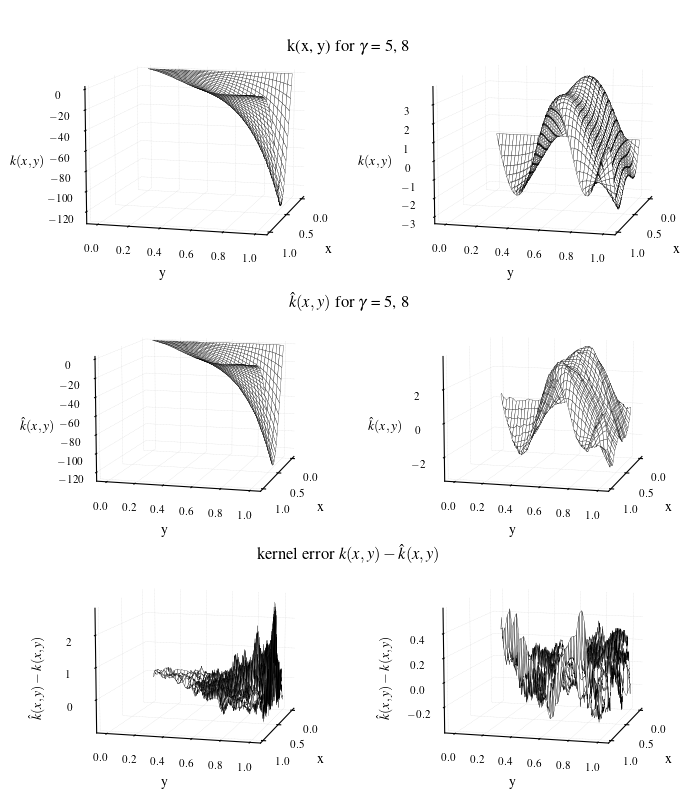

In [120]:
res = 5
fig = plt.figure(figsize=set_size(516, 0.99, (3, 2), height_add=1))
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0)

#### KERNEL PLOT ####
subfig = subfigs[0]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"k(x, y) for $\gamma$ = 5, 8")
meshx, mesht = np.meshgrid(spatial, spatial)

ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
ax[0].plot_surface(meshx, mesht, zeroToNan(karr[0]), edgecolor="black",lw=0.2, rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_zlabel(r"$k(x, y)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].plot_surface(meshx, mesht, zeroToNan(karr[1]), edgecolor="black",lw=0.2,rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_zlabel(r"$k(x, y)$")
ax[1].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[1].zaxis.set_rotate_label(False)


ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#### KERNEL PLOT ####
subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"$\hat{k}(x, y)$ for $\gamma$ = 5, 8")
meshx, mesht = np.meshgrid(spatial, spatial)

ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
ax[0].plot_surface(meshx, mesht, zeroToNan(khatarr[0]), edgecolor="black",lw=0.2, rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_zlabel(r"$\hat{k}(x, y)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].plot_surface(meshx, mesht, zeroToNan(khatarr[1]), edgecolor="black",lw=0.2,rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_zlabel(r"$\hat{k}(x, y)$")
ax[1].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[1].zaxis.set_rotate_label(False)


ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#### ERROR PLOT ####
subfig = subfigs[2]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"kernel error $k(x, y) - \hat{k}(x, y)$")
meshx, mesht = np.meshgrid(spatial, spatial)

ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
ax[0].plot_surface(meshx, mesht, zeroToNan(khatarr[0]-karr[0]), edgecolor="black",lw=0.2, rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_zlabel(r"$\hat{k}(x,y) - k(x, y)$", rotation=90)
ax[0].set_xticks([0, 0.5, 1])
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].plot_surface(meshx, mesht, zeroToNan(khatarr[1]-karr[1]), edgecolor="black",lw=0.2,rstride=res, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_zlabel(r"$\hat{k}(x,y) - k(x, y)$", rotation=90)
ax[1].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[1].zaxis.set_rotate_label(False)


ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


##### ERROR L2 PLOT ####
# subfig = subfigs[1]
# subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

# zticks = np.linspace(-50, 50, 5)
# subfig.suptitle(r"$\lambda(x)=50\cos(\gamma \cos^{-1}(x))$ $\gamma=5, 8$")
# ax = subfig.subplots(nrows=1, ncols=2)
# subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
# ax[0].plot(spatial, lamValArr[0])
# ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[0].set_xlabel("x", labelpad=10)
# ax[0].set_ylabel(r"$\lambda(x)$")
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[0].set_yticks(zticks)

# ax[1].plot(spatial, lamValArr[1])
# ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# ax[1].set_xlabel("x", labelpad=10)
# ax[1].set_ylabel(r"$\lambda(x)$")
# ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[1].set_yticks(zticks)
#plt.savefig("kernelCompare.pdf", dpi=2000)

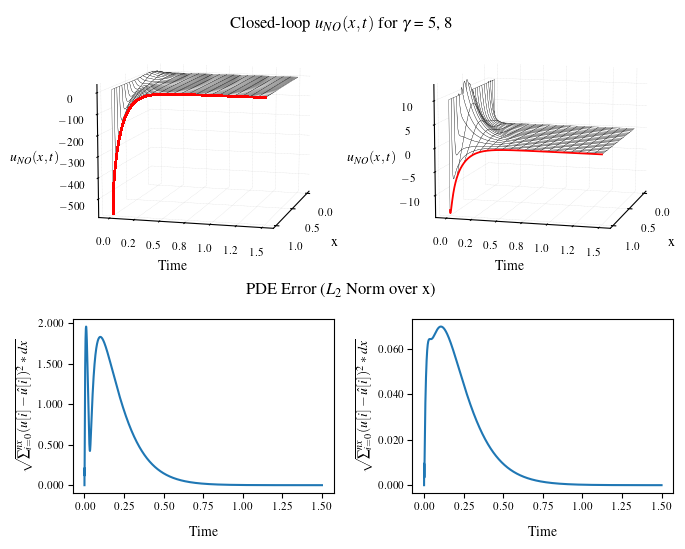

In [121]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.09, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
ax[0].plot_surface(meshx, mesht, uhatarr[0], edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)    
test = np.ones(int(nt))
vals = (uhatarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u_{NO}(x, t)$", labelpad=6)
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uhatarr[1], edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (uhatarr[1].transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$u_{NO}(x, t)$", labelpad=6)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


##### ERROR L2 PLOT ####
subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

zticks = np.linspace(-50, 50, 5)
subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[0].plot(temporal[:-1], getPDEl2(uarr[0], uhatarr[0]))
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("Time", labelpad=10)
ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax[1].plot(temporal[:-1], getPDEl2(uarr[1], uhatarr[1]))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("Time", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#plt.savefig("closedLoop.pdf", dpi=2000)

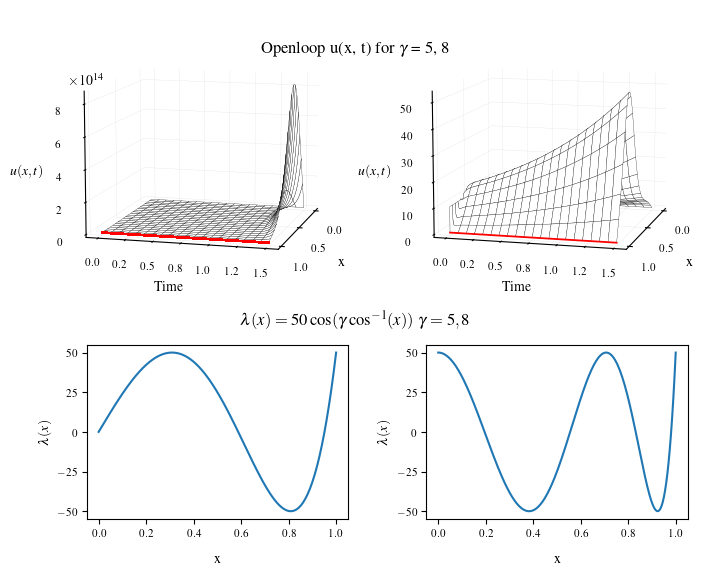

In [122]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

#### OPEN LOOP PLOT ####
subfig = subfigs[0]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"Openloop u(x, t) for $\gamma$ = 5, 8")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uopenarr[0], edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (uopenarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uopenarr[1], edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(nt))
vals = (uopenarr[1].transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$u(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].get_zaxis().get_offset_text().set_visible(False)
ax[0].annotate(r"$\times 10^{14}$", xy=(0.05, .75), xycoords='axes fraction')

##### LAMBDA PLOT ####
lam1 = np.zeros(nx+1)
lam2 = np.zeros(nx+1)
for j in range(nx+1):
    lam1[j] = 50*math.cos(lamarr[0]*math.acos(spatial[j]))
    lam2[j] = 50*math.cos(lamarr[1]*math.acos(spatial[j]))

subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

zticks = np.linspace(-50, 50, 5)
subfig.suptitle(r"$\lambda(x)=50\cos(\gamma \cos^{-1}(x))$ $\gamma=5, 8$")
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[0].plot(spatial, lam1)
ax[0].set_xlabel("x", labelpad=10)
ax[0].set_ylabel(r"$\lambda(x)$")
ax[0].set_yticks(zticks)

ax[1].plot(spatial, lam2)
ax[1].set_xlabel("x", labelpad=10)
ax[1].set_ylabel(r"$\lambda(x)$")
ax[1].set_yticks(zticks)


#plt.savefig("parabolicExamples.pdf", dpi=2000)

In [134]:
# Compare times for calculation. 10^3 improvement on rtx 3090ti
timeSum2 = 0
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        s = time.time() 
        out = model((x, grid))
        timeSum2 += time.time()-s
print(timeSum2/100)

2.3956298828125e-05


In [135]:
timeSum = 0
for i in range(100):
    s = time.time()
    k = solveIntegralFD(X, nx, spatial, lam)
    timeSum += time.time()-s
print(timeSum/100)

0.023923983573913576


In [136]:
print(timeSum/timeSum2)

998.6510748407643
